In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import csv
from keras import models
from keras import layers
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from geneticalgorithm import geneticalgorithm as ga
from matplotlib import pyplot as plt

In [2]:
print("GPU dostępny:", tf.config.list_physical_devices('GPU'))

GPU dostępny: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Rough Set Flow Graph (RSFG)

In [3]:
def get_rsfg(sis):
    
    num_cols = sis.shape[1]

    rsfg_columns = ["level", "relation", "support", "certainty", "coverage", "strength"]

    rsfg_df = pd.DataFrame(columns=rsfg_columns)

    for level in range(num_cols - 1):
        
        edge_counts = {}
        source_counts = {}
        target_counts = {}
        total_possible = len(sis.iloc[:, level + 1])
        
        for _, row in sis.iterrows():
            
            source = str(row.iloc[level])
            target = str(row.iloc[level + 1])
            key = (source, target)
            edge_counts[key] = edge_counts.get(key, 0) + 1
            source_counts[source] = source_counts.get(source, 0) + 1
            target_counts[target] = target_counts.get(target, 0) + 1
            
        for (source, target), count in edge_counts.items():
            
            cer = count / source_counts[source] if source_counts[source] else 0
            cov = count / target_counts[target] if target_counts[target] else 0
            str_value = count / total_possible if total_possible else 0
            lev = f"{level}<>{level+1}"
            rel = f"{source}-->{target}"
            
            new_row = pd.DataFrame(data=np.array([[lev, rel, count, f"{cer:.6f}", f"{cov:.6f}", f"{str_value:.6f}"]]), columns=rsfg_columns)
            
            rsfg_df = pd.concat([rsfg_df, new_row], ignore_index=True)

    return rsfg_df

## Data (MNIST)

In [4]:
(x_train_valid, y_train_valid), (x_test, y_test) = mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, stratify=y_train_valid)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train/255.0
x_valid = x_valid/255.0
x_test = x_test/255.0

y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

# Model (unreadable)

### Load model and dataframe, if you already have them locally:

In [ ]:
model = models.load_model('mnist_model.keras')

In [ ]:
artifact_clusters = pd.read_csv('artifact_clusters.csv')
print(artifact_clusters)

# Start training if no model loaded locally

In [5]:
artifact_clusters = pd.DataFrame()
print(artifact_clusters)

Empty DataFrame
Columns: []
Index: []


In [6]:
n_filters_conv_1 = 4
filter_size_conv_1 = 5
n_filters_conv_2 = 4
filter_size_conv_2 = 5
n_neurons_dense_1 = 50
n_neurons_dense_2 = 10

n_epochs = 20
batch_size = 16

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(n_filters_conv_1, (filter_size_conv_1, filter_size_conv_1), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
model.add(layers.Conv2D(n_filters_conv_2, (filter_size_conv_2, filter_size_conv_2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(n_neurons_dense_1, activation='relu'))
model.add(layers.Dense(n_neurons_dense_2, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/ms/DEV/huretex/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-30 09:42:39.596435: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-04-30 09:42:39.596461: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-30 09:42:39.596466: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-04-30 09:42:39.596483: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-30 09:42:39.596496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fact

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 4)      │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 4)      │           404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        80,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,068 (316.67 KB)

 Trainable params: 81,068 (316.67 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(x_valid, y_valid), verbose=2)

Epoch 1/20


2025-04-30 09:42:46.643346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3000/3000 - 23s - 8ms/step - accuracy: 0.9404 - loss: 0.2098 - val_accuracy: 0.9597 - val_loss: 0.1687
Epoch 2/20
3000/3000 - 23s - 8ms/step - accuracy: 0.9594 - loss: 0.3319 - val_accuracy: 0.9562 - val_loss: 0.6190
Epoch 3/20
3000/3000 - 23s - 8ms/step - accuracy: 0.9502 - loss: 1.5723 - val_accuracy: 0.9485 - val_loss: 3.1608
Epoch 4/20
3000/3000 - 23s - 8ms/step - accuracy: 0.9435 - loss: 5.8036 - val_accuracy: 0.9245 - val_loss: 12.7110
Epoch 5/20
3000/3000 - 23s - 8ms/step - accuracy: 0.9359 - loss: 16.9487 - val_accuracy: 0.9538 - val_loss: 17.4509
Epoch 6/20
3000/3000 - 23s - 8ms/step - accuracy: 0.9272 - loss: 45.5645 - val_accuracy: 0.9215 - val_loss: 73.4173
Epoch 7/20
3000/3000 - 23s - 8ms/step - accuracy: 0.9167 - loss: 113.3364 - val_accuracy: 0.8703 - val_loss: 283.8820
Epoch 8/20
3000/3000 - 23s - 8ms/step - accuracy: 0.9090 - loss: 258.1271 - val_accuracy: 0.9006 - val_loss: 412.6550
Epoch 9/20
3000/3000 - 24s - 8ms/step - accuracy: 0.8959 - loss: 566.3183 - val_accura

In [10]:
# SAVE MODEL LOCALLY
model.save('mnist_model.keras')

In [11]:
layer_outputs = [layer.output for layer in model.layers]
print("Input: ", model.layers[0].input.shape)
print("Output: ", layer_outputs)
activation_model = models.Model(inputs=model.layers[0].input, outputs=layer_outputs)

Input:  (None, 28, 28, 1)
Output:  [<KerasTensor shape=(None, 24, 24, 4), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>, <KerasTensor shape=(None, 20, 20, 4), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>, <KerasTensor shape=(None, 1600), dtype=float32, sparse=False, ragged=False, name=keras_tensor_6>, <KerasTensor shape=(None, 50), dtype=float32, sparse=False, ragged=False, name=keras_tensor_10>, <KerasTensor shape=(None, 10), dtype=float32, sparse=False, ragged=False, name=keras_tensor_15>]


In [12]:
activations = activation_model.predict(x=x_train)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [13]:
for f in range(n_filters_conv_1):

    print('filter: '+str(f))

    activations_f = activations[0][:,:,:,f]
    print(activations_f.shape)
    activations_f = activations_f.reshape([activations_f.shape[0],activations_f.shape[1]*activations_f.shape[2]])
    print(activations_f.shape)
    ac_f = AgglomerativeClustering(n_clusters=4).fit(activations_f)

    artifact_clusters['l0_f'+str(f)] = ac_f.labels_

filter: 0
(48000, 24, 24)
(48000, 576)
filter: 1
(48000, 24, 24)
(48000, 576)
filter: 2
(48000, 24, 24)
(48000, 576)
filter: 3
(48000, 24, 24)
(48000, 576)


In [14]:
for f in range(n_filters_conv_2):

    print('filter: '+str(f))

    activations_f = activations[1][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0],activations_f.shape[1]*activations_f.shape[2]])
    ac_f = AgglomerativeClustering(n_clusters=4).fit(activations_f) 

    artifact_clusters['l1_f'+str(f)] = ac_f.labels_

filter: 0
filter: 1
filter: 2
filter: 3


In [16]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3
0          1      2      2      1      1      3      0      3
1          0      0      0      0      0      1      1      0
2          0      0      0      0      0      1      0      0
3          3      0      0      0      1      3      0      3
4          2      0      3      2      2      2      2      0
...      ...    ...    ...    ...    ...    ...    ...    ...
47995      0      0      0      0      0      1      0      0
47996      3      0      1      3      1      1      1      0
47997      3      1      1      3      1      3      1      3
47998      0      0      0      0      0      0      3      3
47999      0      0      0      0      0      1      0      0

[48000 rows x 8 columns]


In [17]:
activations_d_1 = activations[3]
ac_d = AgglomerativeClustering(n_clusters=10).fit(activations_d_1)
artifact_clusters['l3'] = ac_d.labels_

In [19]:
predictions = model.predict(x=x_train)
pred = np.argmax(predictions, axis=1)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [20]:
a = [p for p in pred if p == 1]

print(a)
print(len(a))


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [21]:
artifact_clusters['p'] = pred

In [22]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3  l3  p
0          1      2      2      1      1      3      0      3   3  7
1          0      0      0      0      0      1      1      0   0  5
2          0      0      0      0      0      1      0      0   7  3
3          3      0      0      0      1      3      0      3   7  3
4          2      0      3      2      2      2      2      0   5  0
...      ...    ...    ...    ...    ...    ...    ...    ...  .. ..
47995      0      0      0      0      0      1      0      0   7  3
47996      3      0      1      3      1      1      1      0   3  8
47997      3      1      1      3      1      3      1      3   9  1
47998      0      0      0      0      0      0      3      3   7  2
47999      0      0      0      0      0      1      0      0   9  5

[48000 rows x 10 columns]


In [23]:
# SAVE ARIFACT CLUSTERS to
artifact_clusters.to_csv('artifact_clusters.csv', index=False)

In [89]:
e_artifact_clusters = artifact_clusters[artifact_clusters['p'] == 2]

In [90]:
print(e_artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3  l3  p
5          0      0      0      0      0      0      3      0   7  2
12         0      0      0      0      0      0      3      0   7  2
38         0      0      0      0      0      0      3      0   7  2
65         0      2      0      0      0      3      3      3   5  2
70         0      0      0      0      0      0      3      0   7  2
...      ...    ...    ...    ...    ...    ...    ...    ...  .. ..
47975      0      0      0      0      0      0      3      0   0  2
47980      0      0      0      0      0      0      3      0   0  2
47985      0      0      0      0      0      0      3      0   7  2
47989      0      0      2      0      0      0      0      1   2  2
47998      0      0      0      0      0      0      3      3   7  2

[4323 rows x 10 columns]


## Twin (readable)

In [91]:
sis = pd.DataFrame()

In [92]:
sis['conv1'] = e_artifact_clusters.astype(str).loc[:,['l0_f0', 'l0_f1', 'l0_f2', 'l0_f3']].apply('_'.join, axis=1)

In [93]:
sis['conv2'] = e_artifact_clusters.astype(str).loc[:,['l1_f0', 'l1_f1', 'l1_f2', 'l1_f3']].apply('_'.join, axis=1)

In [94]:
sis['dense1'] = e_artifact_clusters['l3']

In [95]:
sis['output'] = e_artifact_clusters['p']

In [96]:
print(sis)

         conv1    conv2  dense1  output
5      0_0_0_0  0_0_3_0       7       2
12     0_0_0_0  0_0_3_0       7       2
38     0_0_0_0  0_0_3_0       7       2
65     0_2_0_0  0_3_3_3       5       2
70     0_0_0_0  0_0_3_0       7       2
...        ...      ...     ...     ...
47975  0_0_0_0  0_0_3_0       0       2
47980  0_0_0_0  0_0_3_0       0       2
47985  0_0_0_0  0_0_3_0       7       2
47989  0_0_2_0  0_0_0_1       2       2
47998  0_0_0_0  0_0_3_3       7       2

[4323 rows x 4 columns]


In [97]:
rsfg = get_rsfg(sis)

In [98]:
print(rsfg)

    level           relation support certainty  coverage  strength
0    0<>1  0_0_0_0-->0_0_3_0    2020  0.604972  0.944367  0.467268
1    0<>1  0_2_0_0-->0_3_3_3       7  0.100000  0.057377  0.001619
2    0<>1  3_0_0_0-->1_3_3_3      11  0.130952  0.224490  0.002545
3    0<>1  0_0_0_0-->1_3_3_3      24  0.007188  0.489796  0.005552
4    0<>1  1_2_1_1-->1_1_1_1       2  0.066667  0.400000  0.000463
..    ...                ...     ...       ...       ...       ...
453  2<>3              8-->2     122  1.000000  0.028221  0.028221
454  2<>3              9-->2     221  1.000000  0.051122  0.051122
455  2<>3              1-->2      24  1.000000  0.005552  0.005552
456  2<>3              6-->2      20  1.000000  0.004626  0.004626
457  2<>3              4-->2      39  1.000000  0.009022  0.009022

[458 rows x 6 columns]


In [99]:
rsfg['confidence'] = 2*rsfg['certainty'].astype(float)*rsfg['coverage'].astype(float)/(rsfg['certainty'].astype(float)+rsfg['coverage'].astype(float))

In [100]:
print(rsfg)

    level           relation support certainty  coverage  strength  confidence
0    0<>1  0_0_0_0-->0_0_3_0    2020  0.604972  0.944367  0.467268    0.737496
1    0<>1  0_2_0_0-->0_3_3_3       7  0.100000  0.057377  0.001619    0.072917
2    0<>1  3_0_0_0-->1_3_3_3      11  0.130952  0.224490  0.002545    0.165413
3    0<>1  0_0_0_0-->1_3_3_3      24  0.007188  0.489796  0.005552    0.014168
4    0<>1  1_2_1_1-->1_1_1_1       2  0.066667  0.400000  0.000463    0.114286
..    ...                ...     ...       ...       ...       ...         ...
453  2<>3              8-->2     122  1.000000  0.028221  0.028221    0.054893
454  2<>3              9-->2     221  1.000000  0.051122  0.051122    0.097271
455  2<>3              1-->2      24  1.000000  0.005552  0.005552    0.011043
456  2<>3              6-->2      20  1.000000  0.004626  0.004626    0.009209
457  2<>3              4-->2      39  1.000000  0.009022  0.009022    0.017883

[458 rows x 7 columns]


In [101]:
levels = rsfg['level'].unique()
print(levels)

['0<>1' '1<>2' '2<>3']


In [102]:
rsfg_layers = list()
node_dicts = list()

for level in levels:

    layer = rsfg.loc[rsfg['level']==level,:]
    layer[['source', 'target']] = layer['relation'].str.split('-->', expand=True)

    if len(node_dicts)==0:
        
        node_dict_1 = {key: i for i, key in enumerate(layer['source'].unique())}
        node_dicts.append(node_dict_1)

        layer['source_id'] = layer['source'].map(node_dict_1)

    else:

        layer['source_id'] = layer['source'].map(node_dicts[-1])        

    node_dict_2 = {key: i for i, key in enumerate(layer['target'].unique())}
    node_dicts.append(node_dict_2)

    layer['target_id'] = layer['target'].map(node_dict_2)
    
    layer = layer[['source_id', 'target_id', 'source', 'target', 'confidence']]
        
    rsfg_layers.append(layer)

/var/folders/0m/y35n_skn6dn_7xxvwx4kq9140000gn/T/ipykernel_8227/1748982612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer[['source', 'target']] = layer['relation'].str.split('-->', expand=True)
/var/folders/0m/y35n_skn6dn_7xxvwx4kq9140000gn/T/ipykernel_8227/1748982612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer[['source', 'target']] = layer['relation'].str.split('-->', expand=True)
/var/folders/0m/y35n_skn6dn_7xxvwx4kq9140000gn/T/ipykernel_8227/1748982612.py:14: SettingWithCopyWarni

## Genetic Algorithm

https://pypi.org/project/geneticalgorithm/

In [103]:
def fitness(x):

    confidences = list()

    for i in range(len(x)-1):

        layer = rsfg_layers[i]

        confidence = layer.loc[(layer['source_id']==x[i]) & (layer['target_id']==x[i+1]), ['confidence']]

        if len(confidence)==0:

            return 0
            
        confidences.append(confidence['confidence'])

    return -np.min(np.array(confidences))  

[[0, 60], [0, 60], [0, 9], [0, 0]]
 The best solution found:                                                                           
 [0. 0. 3. 0.]

 Objective function:
 -0.4112458374640942


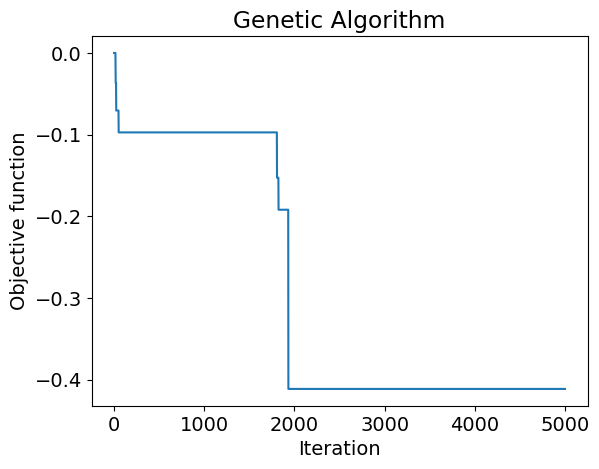

In [104]:
parameters = {'max_num_iteration': 5000,
              'population_size': 20,
              'parents_portion': 0.3,
              'mutation_probability':0.1,
              'crossover_probability': 0.1,
              'elit_ratio': 0.01,
              'crossover_type':'uniform',
              'max_iteration_without_improv': None}


varbounds = []

for d in node_dicts:

    varbounds.append([0,len(d)-1])

print(varbounds)

gen_alg = ga(function=fitness, dimension=len(varbounds), variable_type='int', variable_boundaries=np.array(varbounds), algorithm_parameters=parameters)

gen_alg.run()

In [105]:
best_path = gen_alg.output_dict['variable']

In [106]:
best_path_info = pd.DataFrame(columns=['confidence', 'source', 'target'])

for i in range(len(best_path)-1):

        layer = rsfg_layers[i]

        path_info = layer.loc[(layer['source_id']==best_path[i]) & (layer['target_id']==best_path[i+1]), ['confidence', 'source', 'target']]
    
        best_path_info = pd.concat([best_path_info.dropna(axis=1, how='all') , path_info], ignore_index=True)

print(best_path_info)

   confidence   source   target
0    0.737496  0_0_0_0  0_0_3_0
1    0.423573  0_0_3_0        0
2    0.411246        0        2


## Visualization

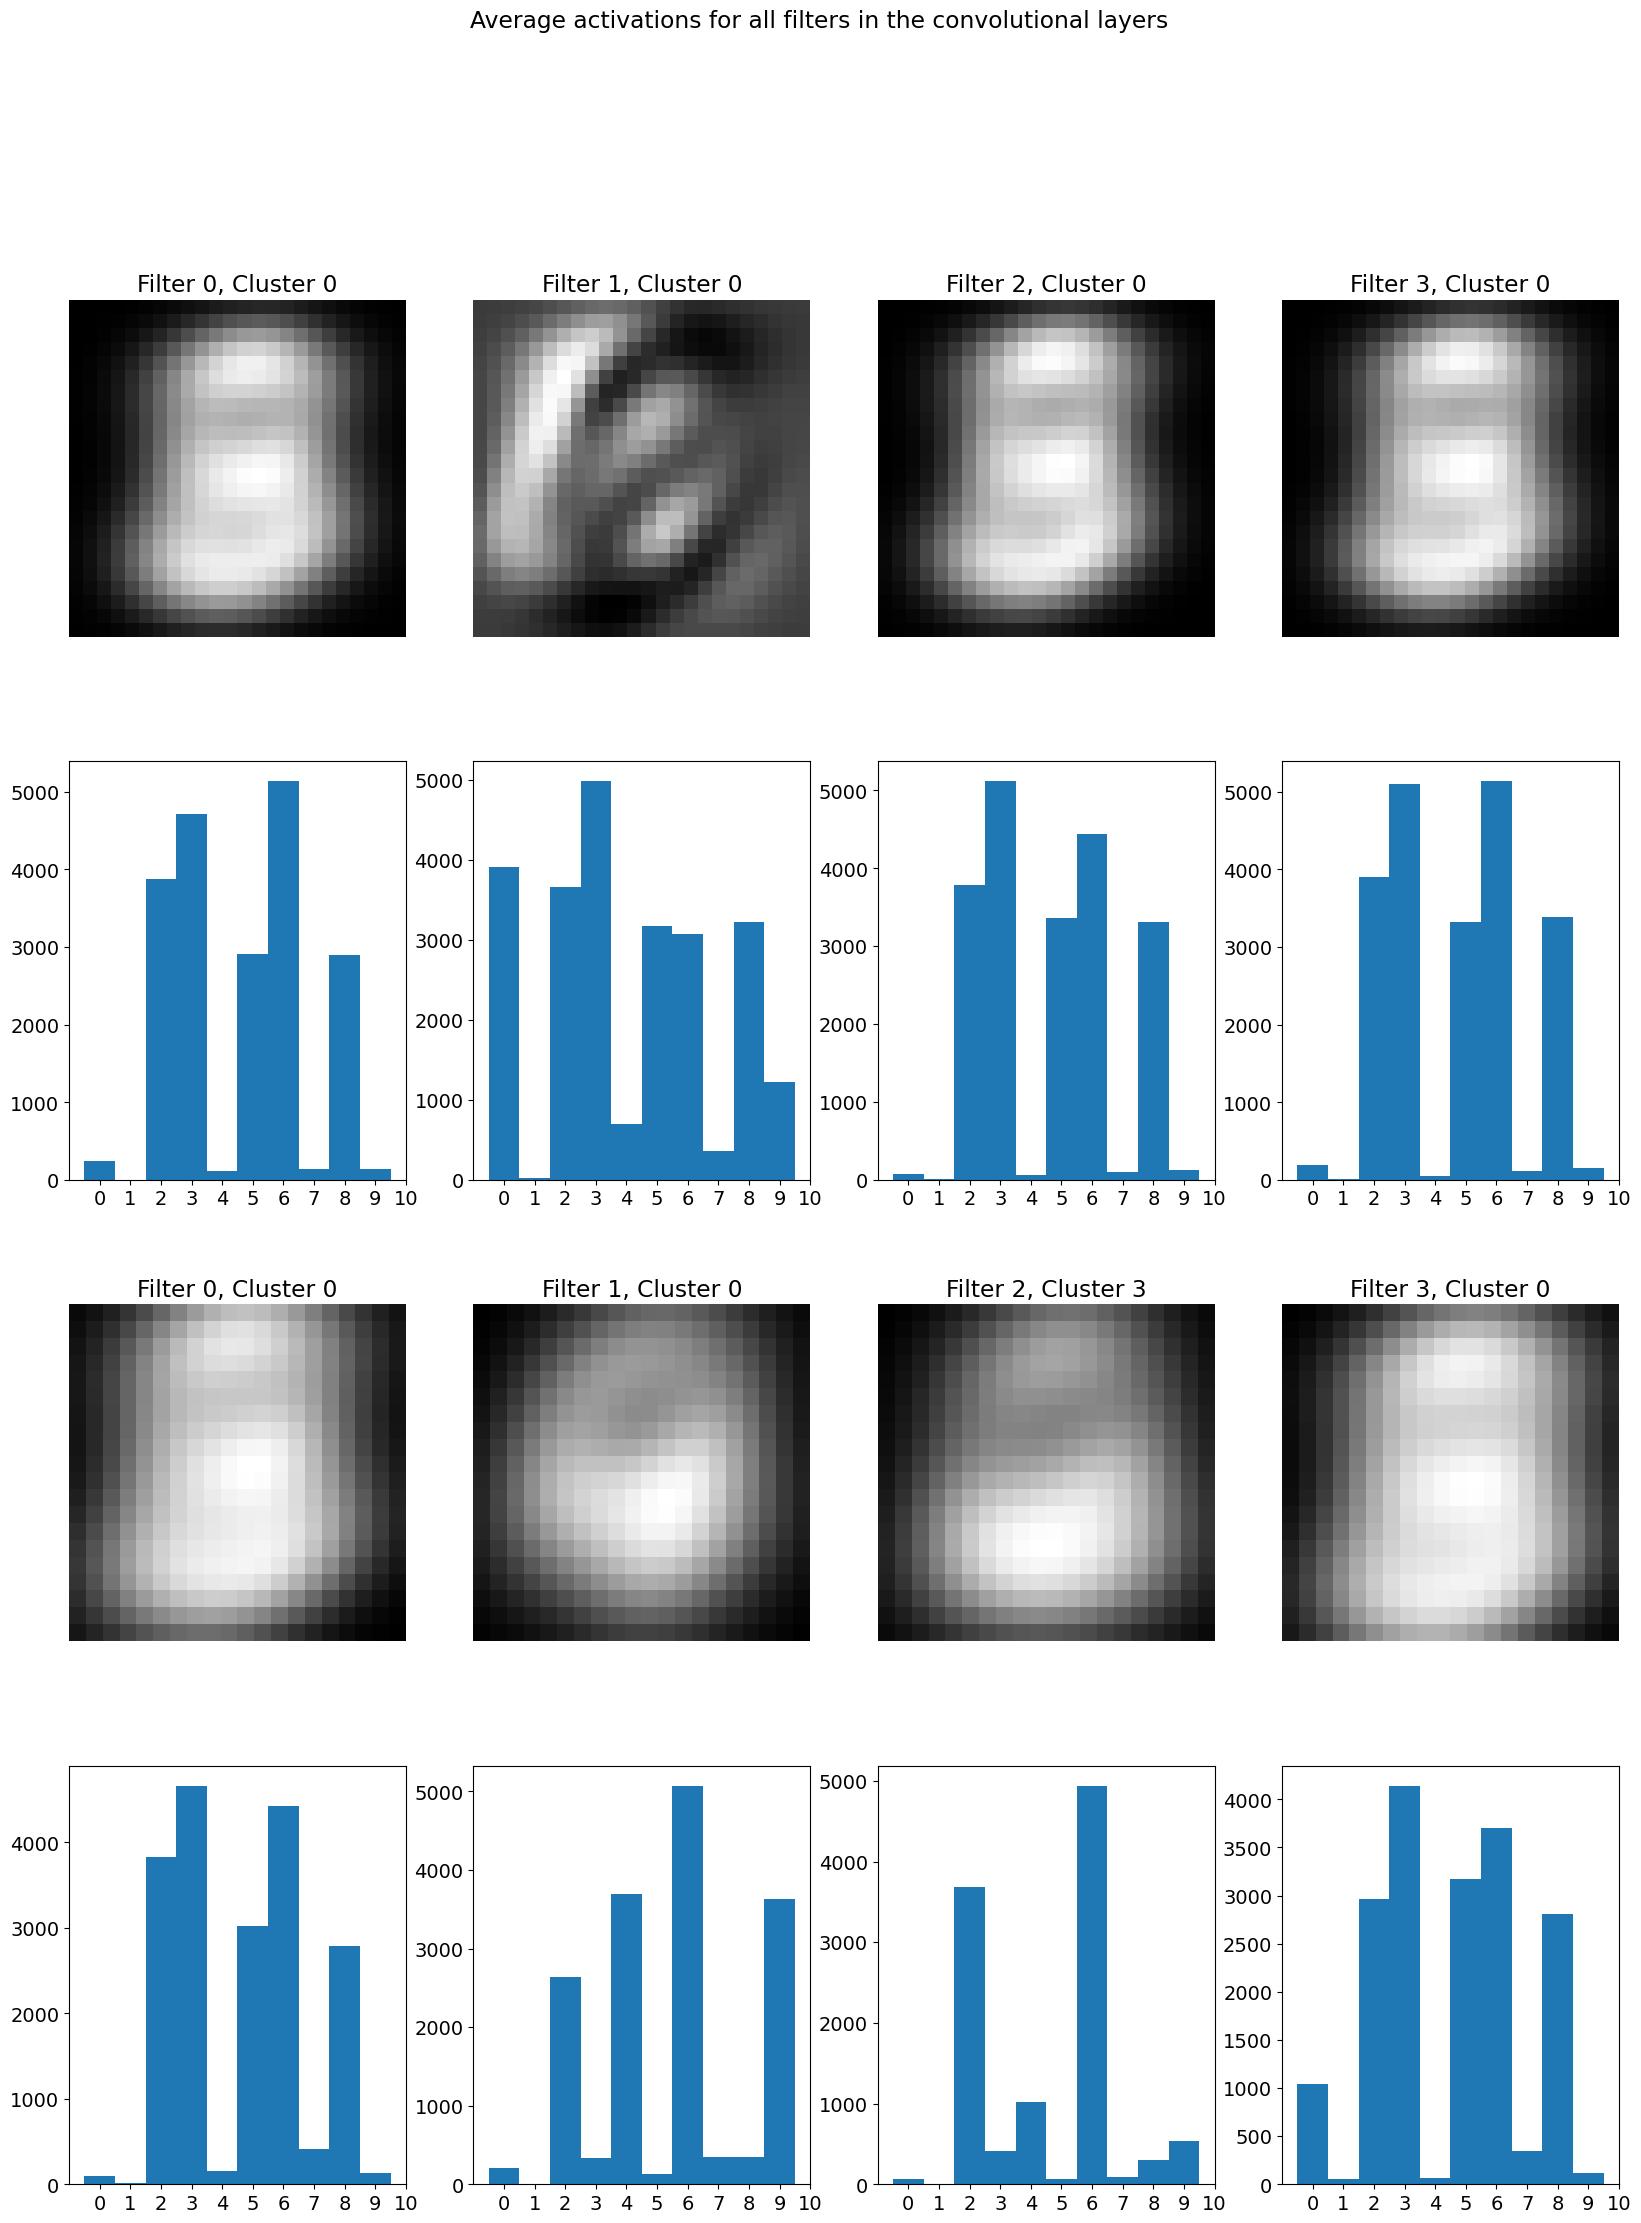

In [107]:
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(4, 4, figsize=(20, 25)) 
fig.suptitle("Average activations for all filters in the convolutional layers")

source_cluster_indexes = best_path_info.loc[:,'source'].str.split('_')
target_cluster_indexes = best_path_info.loc[:,'target'].str.split('_')

row = 0

for filter_index in range(4):

    source_cluster_index = int(source_cluster_indexes[0][filter_index])
    target_cluster_index = int(target_cluster_indexes[0][filter_index])
    
    activation_data_0 = activations[0][artifact_clusters[f'l0_f{filter_index}'] == source_cluster_index, :, :, filter_index]
    cluster_0 = artifact_clusters.loc[artifact_clusters[f'l0_f{filter_index}'] == source_cluster_index, :]

    activation_data_1 = activations[1][artifact_clusters[f'l1_f{filter_index}'] == target_cluster_index, :, :, filter_index]
    cluster_1= artifact_clusters.loc[artifact_clusters[f'l1_f{filter_index}'] == target_cluster_index, :]

    average_activation_0 = np.mean(activation_data_0, axis=0)
    average_activation_1 = np.mean(activation_data_1, axis=0)

    col = filter_index
            
    axes[2*row, col].imshow(average_activation_0, cmap=plt.get_cmap('gray'))
    axes[2*row, col].axis("off")
    axes[2*row, col].set_title(f"Filter {filter_index}, Cluster {source_cluster_index}")

    bins = np.arange(0, 9 + 1.5) - 0.5
    axes[2*row+1, col].hist(cluster_0['p'], bins)
    axes[2*row+1, col].set_xticks(bins + 0.5)

    axes[2*row+2, col].imshow(average_activation_1, cmap=plt.get_cmap('gray'))
    axes[2*row+2, col].axis("off")
    axes[2*row+2, col].set_title(f"Filter {filter_index}, Cluster {target_cluster_index}")

    bins = np.arange(0, 9 + 1.5) - 0.5
    axes[2*row+3, col].hist(cluster_1['p'], bins)
    axes[2*row+3, col].set_xticks(bins + 0.5)

plt.show()

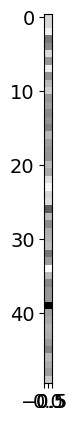

In [108]:
activation_data_3 = activations[3][artifact_clusters[f'l0_f{filter_index}'] == source_cluster_index, :]
activation_data_3 = np.mean(activation_data_3, axis=0)
plt.imshow(activation_data_3.reshape(activation_data_3.shape[0], 1, 1), cmap=plt.get_cmap('gray'))